In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_494/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import functools

In [5]:
from collections import Counter

In [6]:
sns.set_theme(style="darkgrid")


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Load Dataset and create the vobabulary for the given dataset

In [8]:
import json
json_path = '/workspaces/chat-gpt-failures/datasets/galeras_prompting/code_completion_docstring_3k_T2_deduped_tuned.json'
with open(json_path) as json_file:
    json_data = json.load(json_file)

In [9]:
from collections import defaultdict

word_freqs = defaultdict(int)
corpus = [x["code"].strip() for x in json_data]
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'def': 2855, 'Ġrolling': 1, '(': 17301, 'self': 3067, ',': 17015, 'Ġ*': 695, 'args': 512, 'Ġ**': 324, 'kwargs': 306, ')': 8328, 'Ġ->': 611, 'ĠRollingGroupby': 3, ':': 6736, 'ĊĠĠĠĠĠĠĠĠĊĠĠĠĠĠĠĠ': 1445, 'Ġfrom': 483, 'Ġpandas': 48, '.': 25507, 'core': 28, 'window': 41, 'Ġimport': 235, 'ĊĊĠĠĠĠĠĠĠ': 2345, 'Ġreturn': 2667, 'ĊĠĠĠĠĠĠĠĠĠĠĠ': 9919, 'Ġself': 5522, '._': 2224, 'selected': 12, '_': 49261, 'obj': 221, 'Ġ_': 1272, 'grouper': 5, '=': 4877, 'as': 152, 'index': 359, 'ĊĠĠĠĠĠĠĠ': 11892, 'Ġ)': 2005, 'Ġexpected': 199, 'degree': 18, 'graph': 70, 'w': 128, 'Ġseed': 13, 'None': 670, 'Ġselfloops': 3, 'True': 536, '):': 3393, 'ĊĠĠĠ': 5506, 'Ġr': 197, 'Ġn': 423, 'Ġ=': 11930, 'Ġlen': 496, 'ĠG': 137, 'Ġnx': 62, 'empty': 69, 'n': 567, 'ĊĊĠĠĠ': 1634, 'Ġ#': 4274, 'ĠIf': 107, 'Ġthere': 54, 'Ġare': 226, 'Ġno': 149, 'Ġnodes': 69, 'Ġedges': 18, 'Ġin': 2948, 'Ġthe': 1743, 'Ġgraph': 44, 'Ġempty': 67, 'Ġif': 4325, 'Ġ==': 1539, 'Ġ0': 1153, 'Ġor': 596, 'Ġmax': 204, 'Ġrho': 4, 'Ġ1': 

In [10]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '¤', '¥', '¨', '«', '¬', '®', '¯', '°', '³', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'Â', 'Ã', 'Ç', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ð', 'ĉ', 'Ċ', 'č', 'Ġ', 'Ģ', 'Ĥ', 'ĥ', 'Ħ', 'ħ', 'Ĩ', 'ĩ', 'Ī', 'ī', 'ĭ', 'Į', 'į', 'ı', 'Ĳ', 'Ķ', 'ķ', 'ĺ', 'Ļ', 'Ľ', 'ľ', 'Ŀ', 'ŀ', 'Ł', 'ł', 'Ń']


In [11]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [12]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [13]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [14]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('d', 'e'): 11832
('e', 'f'): 4532
('Ġ', 'r'): 7879
('r', 'o'): 6727
('o', 'l'): 3186
('l', 'l'): 2843


In [15]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 'Ġ') 382197


In [16]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [17]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [18]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [19]:
vocab_size = 1024

In [20]:
len(vocab)

159

In [21]:
while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [22]:
len(vocab)

1024

In [23]:
print(merges)

{('Ġ', 't'): 'Ġt', ('Ġ', 'Ġ'): 'ĠĠ', ('ĠĠ', 'ĠĠ'): 'ĠĠĠĠ', ('ĠĠ', 'Ġ'): 'ĠĠĠ', ('Ċ', 'ĠĠĠĠ'): 'ĊĠĠĠĠ', ('s', 'e'): 'se', ('ĊĠĠĠĠ', 'ĠĠĠĠ'): 'ĊĠĠĠĠĠĠĠĠ', ('r', 'e'): 're', ('i', 'n'): 'in', ('ĊĠĠĠĠ', 'ĠĠĠ'): 'ĊĠĠĠĠĠĠĠ', ('o', 'n'): 'on', ('a', 't'): 'at', ('Ġ', '='): 'Ġ=', ('e', 'r'): 'er', ('s', 't'): 'st', ('o', 'r'): 'or', ('d', 'e'): 'de', ('ĊĠĠĠĠĠĠĠĠ', 'ĠĠĠ'): 'ĊĠĠĠĠĠĠĠĠĠĠĠ', ('a', 'l'): 'al', ('e', 'n'): 'en', ('se', 'l'): 'sel', ('Ġ', 'i'): 'Ġi', ('ĊĠĠĠĠĠĠĠĠ', 'ĠĠĠĠ'): 'ĊĠĠĠĠĠĠĠĠĠĠĠĠ', ('sel', 'f'): 'self', ('a', 'r'): 'ar', ('Ċ', 'ĠĠĠ'): 'ĊĠĠĠ', ('a', 'n'): 'an', ('l', 'e'): 'le', ('m', 'e'): 'me', ('Ġ', 'f'): 'Ġf', ('a', 's'): 'as', ('Ġ', 'c'): 'Ġc', ('Ġ', '"'): 'Ġ"', ('t', 'i'): 'ti', ('g', 'e'): 'ge', ('Ġ', 'n'): 'Ġn', ('Ġ', 're'): 'Ġre', ('t', 'e'): 'te', ('Ġ', 'self'): 'Ġself', ('c', 'e'): 'ce', ('h', 'e'): 'he', ('u', 'r'): 'ur', ('r', 'o'): 'ro', ('ĊĠĠĠĠĠĠĠĠĠĠĠĠ', 'ĠĠĠ'): 'ĊĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ', ('Ġ', 'in'): 'Ġin', ('l', 'o'): 'lo', (')', ':'): '):', ('Ġ', 'p'): 'Ġp', ('u', '

In [24]:
print(vocab)

['<|endoftext|>', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '¤', '¥', '¨', '«', '¬', '®', '¯', '°', '³', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'Â', 'Ã', 'Ç', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ð', 'ĉ', 'Ċ', 'č', 'Ġ', 'Ģ', 'Ĥ', 'ĥ', 'Ħ', 'ħ', 'Ĩ', 'ĩ', 'Ī', 'ī', 'ĭ', 'Į', 'į', 'ı', 'Ĳ', 'Ķ', 'ķ', 'ĺ', 'Ļ', 'Ľ', 'ľ', 'Ŀ', 'ŀ', 'Ł', 'ł', 'Ń', 'Ġt', 'ĠĠ', 'ĠĠĠĠ', 'ĠĠĠ', 'ĊĠĠĠĠ', 'se', 'ĊĠĠĠĠĠĠĠĠ', 're', 'in', 'ĊĠĠĠĠĠĠĠ', 'on', 'at', 'Ġ=', 'er', 'st', 'or', 'de', 'ĊĠĠĠĠĠĠĠĠĠĠĠ', 'al', 'en', 'sel', 'Ġi', 'ĊĠĠĠĠĠĠĠĠĠĠĠĠ', 'self', 'ar', 'ĊĠ

In [25]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

In [26]:
tokenize("def function:")

['def', 'Ġf', 'unction', ':']

## II. Tokenize each sentence with BPE for each Treatment and Groundtruth

In [27]:
bpe_tokenized = [tokenize(x["code"].strip())for x in json_data]

In [28]:
ground_truth = [[x["code"].strip(),len(x["code"].split()), bpe_tokenized[i], len(bpe_tokenized[i])] for i, x in enumerate(json_data)]

In [29]:
bpe_control = [tokenize(x["control"]["predicted"]["prediction"].strip()) for x in json_data]

In [30]:
control_t = [[x["control"]["predicted"]["prediction"].strip(),len(x["control"]["predicted"]["prediction"].split()), bpe_control[i], len(bpe_control[i])] for i, x in enumerate(json_data)]

In [31]:
assert len(control_t) == len(ground_truth)

In [32]:
bpe_T1 = [tokenize(x["T1"]["predicted"]["prediction"].strip())for x in json_data]

In [33]:
T1_t = [[x["T1"]["predicted"]["prediction"].strip(),len(x["T1"]["predicted"]["prediction"].split()), bpe_T1[i], len(bpe_T1[i])] for i, x in enumerate(json_data)]

In [34]:
bpe_T2 = [tokenize(x["T2"]["predicted"]["prediction"].strip())for x in json_data]

In [35]:
T2_t = [[x["T2"]["predicted"]["prediction"].strip(),len(x["T2"]["predicted"]["prediction"].split()), bpe_T2[i], len(bpe_T2[i])] for i, x in enumerate(json_data)]

In [36]:
gt_df = pd.DataFrame(ground_truth)
gt_df = gt_df.set_axis(["code","n_words_gt","gt_bpe_tokens", "gt_bpe_size"], axis=1)

In [37]:
control_df = pd.DataFrame(control_t)
control_df = control_df.set_axis(["control","n_words_c","control_bpe_tokens", "control_bpe_size"], axis=1)

In [38]:
T1_df = pd.DataFrame(T1_t)
T1_df = T1_df.set_axis(["T1","n_words_T1","T1_bpe_tokens", "T1_bpe_size"], axis=1)

In [39]:
T2_df = pd.DataFrame(T2_t)
T2_df = T2_df.set_axis(["T2","n_words_T2","T2_bpe_tokens", "T2_bpe_size"], axis=1)

In [40]:
result = pd.concat([gt_df,control_df,T1_df,T2_df], axis=1)

In [41]:
result.shape

(2923, 16)

In [42]:
result.head()

,code,n_words_gt,gt_bpe_tokens,gt_bpe_size,control,n_words_c,control_bpe_tokens,control_bpe_size,T1,n_words_T1,T1_bpe_tokens,T1_bpe_size,T2,n_words_T2,T2_bpe_tokens,T2_bpe_size
0,"def rolling(self, *args, **kwargs) -> RollingG...",18,"[def, Ġro, ll, ing, (, self, ,, Ġ*, args, ,, Ġ...",93,Certainly! Here's the completed code:\n\n```py...,72,"[C, er, ta, in, ly, !, Ġ, H, e, re, ', s, Ġthe...",235,Here's the completed method:\n\n```\ndef rolli...,64,"[H, e, re, ', s, Ġthe, Ġco, mple, ted, Ġme, th...",229,"Sure, here's the code for the rolling function...",47,"[S, ure, ,, Ġhe, re, ', s, Ġthe, Ġc, ode, Ġfor...",133
1,"def expected_degree_graph(w, seed=None, selflo...",179,"[def, Ġexpected, _, de, g, ree, _, g, raph, (,...",439,Here is the completed python method:\n\n```pyt...,332,"[H, e, re, Ġis, Ġthe, Ġco, mple, ted, Ġpy, th,...",836,```python\nimport networkx as nx\nimport math\...,345,"[`, `, `, py, th, on, Ċ, i, mport, Ġn, et, wor...",866,Here is the code for the `expected_degree_grap...,138,"[H, e, re, Ġis, Ġthe, Ġc, ode, Ġfor, Ġthe, Ġ`,...",374
2,"def save(self, path):\n \n os.ma...",49,"[def, Ġs, ave, (, self, ,, Ġpath, ):, ĊĠĠĠĠĠĠĠ...",316,exist_ok=True),1,"[ex, ist, _, ok, =, True, )]",7,```exist_ok=True)\n filename = os.path....,58,"[`, `, `, ex, ist, _, ok, =, True, ), ĊĠĠĠĠĠĠĠ...",167,"```python\nimport os\n\ndef save(self, path):\...",25,"[`, `, `, py, th, on, Ċ, i, mport, Ġos, Ċ, Ċ, ...",114
3,def test_build_group_generic_issue_attachment(...,51,"[def, Ġtest, _, bu, ild, _, group, _, g, ener,...",324,"""danger""",1,"["", d, an, ger, ""]",5,"""warning""",1,"["", w, arning, ""]",4,Certainly! Here's the code without any additio...,81,"[C, er, ta, in, ly, !, Ġ, H, e, re, ', s, Ġthe...",444
4,"def apply(self, func, mask=None) -> 'ImageProc...",45,"[def, Ġa, p, p, ly, (, self, ,, Ġf, un, c, ,, ...",185,```\n mask = mask.astype(bool)\n ...,32,"[`, `, `, ĊĠĠĠĠĠĠĠ, Ġm, ask, Ġ=, Ġm, ask, ., a...",123,Here's the completed method with the missing p...,151,"[H, e, re, ', s, Ġthe, Ġco, mple, ted, Ġme, th...",433,"```\ndef apply(self, func, mask=None) -> 'Imag...",39,"[`, `, `, Ċ, def, Ġa, p, p, ly, (, self, ,, Ġf...",136


In [50]:
result.to_json('/workspaces/chat-gpt-failures/data/bpe_distribution_code_completion_T2.json')

In [52]:
result = pd.read_json('/workspaces/chat-gpt-failures/data/bpe_distribution_code_completion_T2.json')

Text(0.5, 1.0, 'test')

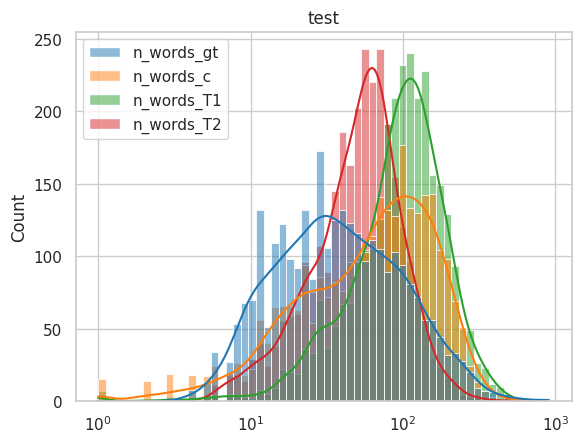

In [53]:
sns.histplot(data=result[["n_words_gt","n_words_c","n_words_T1","n_words_T2"]], kde=True, log_scale=True).set_title("test")

In [54]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [65]:
sns.set_style("whitegrid")

In [66]:
sns.set_palette("tab10")

/tmp/ipykernel_494/1507748530.py:6: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


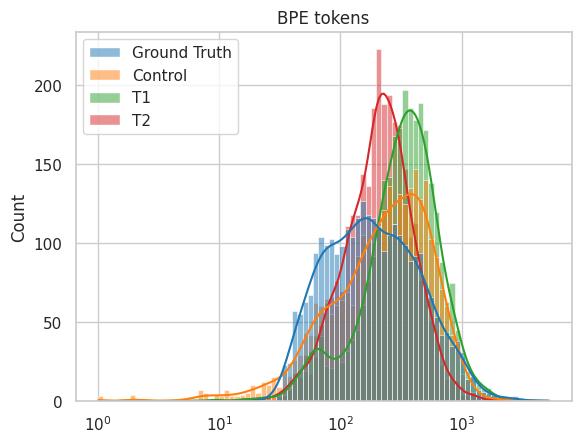

In [67]:
series = ["Ground Truth","Control","T1", "T2"]
fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=result[["gt_bpe_size","control_bpe_size","T1_bpe_size","T2_bpe_size"]], kde=True, log_scale=True, ax=ax1)
sp1.set_title("BPE tokens")
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, series)

Text(0.5, 1.0, 'BPE tokens')

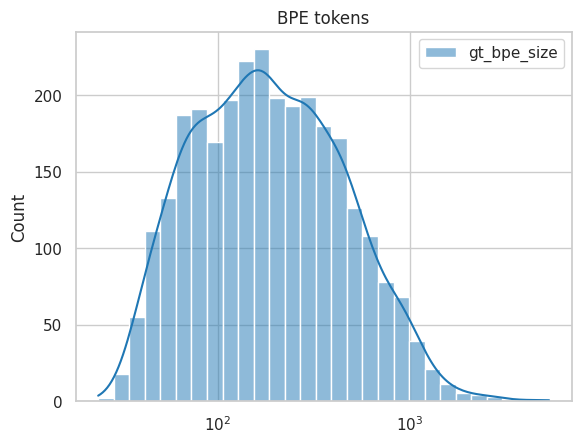

In [71]:
sns.histplot(data=result[["gt_bpe_size"]], kde=True, log_scale=True).set_title("BPE tokens")


Text(0.5, 1.0, 'BPE Tokens')

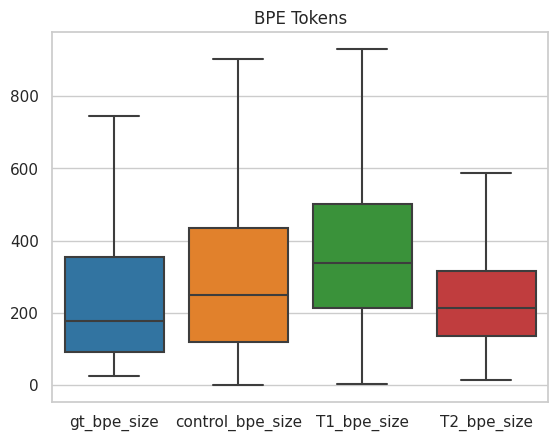

In [72]:
sns.boxplot(data=result[["gt_bpe_size","control_bpe_size","T1_bpe_size","T2_bpe_size"]], showfliers=False).set_title("BPE Tokens")

In [73]:
bpe_keys =["gt_bpe_size","control_bpe_size","T1_bpe_size","T2_bpe_size"]
for key in bpe_keys:
    print(key)
    print(result[key].describe())
    print(result[key].median())

gt_bpe_size
count   2923.00
mean     277.83
std      308.56
min       24.00
25%       91.00
50%      177.00
75%      353.50
max     5267.00
Name: gt_bpe_size, dtype: float64
177.0
control_bpe_size
count   2923.00
mean     308.06
std      258.08
min        1.00
25%      120.00
50%      249.00
75%      435.00
max     3916.00
Name: control_bpe_size, dtype: float64
249.0
T1_bpe_size
count   2923.00
mean     387.94
std      266.04
min        2.00
25%      214.00
50%      339.00
75%      501.00
max     3162.00
Name: T1_bpe_size, dtype: float64
339.0
T2_bpe_size
count   2923.00
mean     253.64
std      181.87
min       15.00
25%      136.00
50%      214.00
75%      317.00
max     2789.00
Name: T2_bpe_size, dtype: float64
214.0


In [74]:
token_count = result.sum()
token_count

code                  def rolling(self, *args, **kwargs) -> RollingG...
n_words_gt                                                       174446
gt_bpe_tokens         [def, Ġro, ll, ing, (, self, ,, Ġ*, args, ,, Ġ...
gt_bpe_size                                                      812109
control               Certainly! Here's the completed code:\n\n```py...
n_words_c                                                        247705
control_bpe_tokens    [C, er, ta, in, ly, !, Ġ, H, e, re, ', s, Ġthe...
control_bpe_size                                                 900463
T1                    Here's the completed method:\n\n```\ndef rolli...
n_words_T1                                                       331229
T1_bpe_tokens         [H, e, re, ', s, Ġthe, Ġco, mple, ted, Ġme, th...
T1_bpe_size                                                     1133943
T2                    Sure, here's the code for the rolling function...
n_words_T2                                                      

In [75]:
bpe_tokenized_df = pd.DataFrame(bpe_tokenized)

In [76]:
bpe_tokenized_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5257,5258,5259,5260,5261,5262,5263,5264,5265,5266
0,def,Ġro,ll,ing,(,self,",",Ġ*,args,",",...,None,None,None,None,None,None,None,None,None,None
1,def,Ġexpected,_,de,g,ree,_,g,raph,(,...,None,None,None,None,None,None,None,None,None,None
2,def,Ġs,ave,(,self,",",Ġpath,):,ĊĠĠĠĠĠĠĠĠĊĠĠĠĠĠĠĠ,Ġos,...,None,None,None,None,None,None,None,None,None,None
3,def,Ġtest,_,bu,ild,_,group,_,g,ener,...,None,None,None,None,None,None,None,None,None,None
4,def,Ġa,p,p,ly,(,self,",",Ġf,un,...,None,None,None,None,None,None,None,None,None,None


In [77]:
counter_tokens = [Counter(bpe_list) for bpe_list in bpe_tokenized]


In [78]:
counter_tokens[2]

Counter({'.': 20,
         'ar': 18,
         'ti': 18,
         'fa': 18,
         'ct': 18,
         '_': 16,
         '(': 13,
         'Ġ': 12,
         ',': 11,
         's': 10,
         'path': 8,
         'Ġ"': 7,
         'ĊĠĠĠĠĠĠĠĠĠĠĠ': 6,
         'name': 6,
         'dir': 5,
         'me': 5,
         ')': 4,
         'ĊĠĠĠĠĠĠĠ': 4,
         'join': 4,
         'json': 4,
         'Ġf': 4,
         'p': 4,
         'Ġos': 3,
         'os': 3,
         '")': 3,
         ':': 3,
         'ĊĊĠĠĠĠĠĠĠ': 3,
         't': 3,
         'ad': 3,
         'ata': 3,
         'i': 3,
         'self': 2,
         'Ġwith': 2,
         'Ġop': 2,
         'en': 2,
         'tri': 2,
         'cs': 2,
         '"),': 2,
         'w': 2,
         'Ġas': 2,
         'du': 2,
         'mp': 2,
         'Ġ=': 2,
         'Ġ{': 2,
         'ĊĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ': 2,
         'ur': 2,
         '":': 2,
         'class': 2,
         'Ġ}': 2,
         'Ġfor': 2,
         'Ġin': 2,
         'Ġself': 2,


In [79]:
total_token_count = Counter()
for row in counter_tokens:
    total_token_count = total_token_count+row


In [80]:
def print_token_distribution( dict_most, ax, log = False, label=['Control'], title='' ):

    
    ax.bar(dict_most.keys(), dict_most.values(), width=(0.3*((-1)**10)), align='edge', alpha=.6, label="test")
    
    ax.set_ylabel('N. Tokens')
    ax.set_title('Token by taxonomy '+ title)
    ax.legend()

    if log:
        ax.set_yscale("log")


In [81]:
TOK=10

In [82]:
dict_most =dict(total_token_count.most_common(TOK))

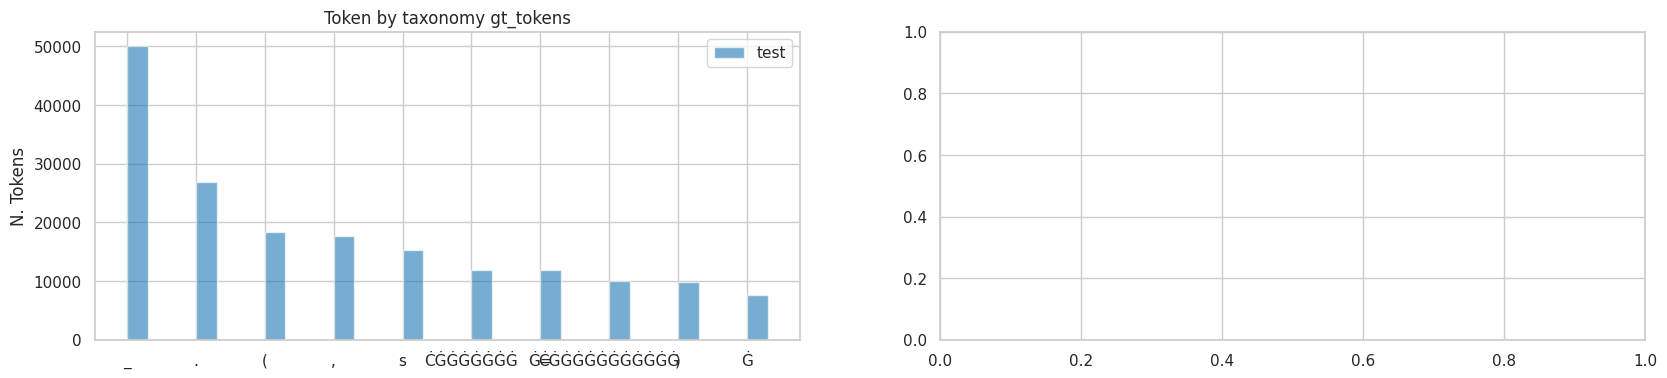

In [83]:
fig, axs = plt.subplots( figsize=(20,4), ncols=2 )

print_token_distribution( dict_most, axs[0], label=['inputs'], title= 'gt_tokens')

## IV. Grouping tokens

### Token Distirbution

In [84]:
treatments = ["gt_bpe_tokens","control_bpe_tokens","T1_bpe_tokens","T2_bpe_tokens"]


In [85]:
def token_distribution( method_vector ):
    '''Return a Counter Object'''
    cnt = Counter()
    for method in method_vector:
        for token in method:
            cnt[token] += 1
    return cnt

In [86]:
def token_distribution_dict(super_data_):
    dct_control = {}
    for label in treatments:
        dct_control[label] = [ token_distribution( super_data_[label].values)]
    return dct_control

In [87]:
dct_control = token_distribution_dict( result ) # [WARNING!] Time consuming

In [88]:
proposed_token = ['assert','test','def','class','lambda','if','else','for']

In [89]:
def count_by_taxonomy( dct_control, k_token = ['assert'], stringent = False, flag = False ):
    "Counting the token across BPEs"
    dict_most_k_tok = dict.fromkeys( k_token, 0 )
    for k in dct_control.keys():
        for k_tok in k_token:
            if stringent:
                if k_tok == k:
                    dict_most_k_tok[k_tok] +=  dct_control[ k ]
                    if flag:
                        print( k +" : "+ str(dct_control[ k ]) )
            else:
                tmp = 'Ġ'+ k_tok
                #if k_tok in k:
                if k_tok == k or tmp == k:    
                    dict_most_k_tok[k_tok] +=  dct_control[ k ]
                    if flag:
                        print( k +" : "+ str(dct_control[ k ]) )
                
    return Counter(dict_most_k_tok)

In [90]:
dct_control.keys()

dict_keys(['gt_bpe_tokens', 'control_bpe_tokens', 'T1_bpe_tokens', 'T2_bpe_tokens'])

In [91]:
count_by_taxonomy(dct_control)

Counter({'assert': 0})

In [92]:
def count_by_taxonomy_list(list_dct_control, k_token = ['assert'], stringent = False ):
    ''''Flatting function for Source/Target datasets'''
    return [ dict( count_by_taxonomy( dct_control, k_token , stringent ) ) for dct_control in list_dct_control]

In [93]:
focused_tokens_non = { split :  count_by_taxonomy_list( dct_control[split], k_token = proposed_token )  for split in dct_control}

In [92]:
(0.3*((2)**2))

1.2

In [94]:
import numpy as np

In [95]:
def print_token_distribution( dict_most, ax, log = False, label=['Control'], width=0.2, title='' ):
    multiplier = 0
    keywords = dict_most[0].keys()
    x = np.arange(len(keywords))  
    for count, label_ in enumerate(label):
        offset = width * multiplier
        rects = ax.bar(x + offset, dict_most[count].values(), width=width, align='center', alpha=.6, label=label_)
        #ax.bar_label(rects, padding=3)
        multiplier +=1
    ax.set_ylabel('N. Tokens')
    ax.set_title('Token by taxonomy '+ title)
    ax.set_xticks(x + width, keywords)
    ax.legend(loc='upper left', ncols=3)

    

    if log:
        ax.set_yscale("log")

    

## Top 10 most popular

In [99]:
TOK = 10
dict_most = {}

for dct_cnt in dct_control:
    dict_most[dct_cnt] = [
        dict(dct_control[dct_cnt][0].most_common( TOK ))  
    ] #<---Hyperparameter

In [100]:
dict_most[key][0]

KeyError: 'T2_bpe_size'

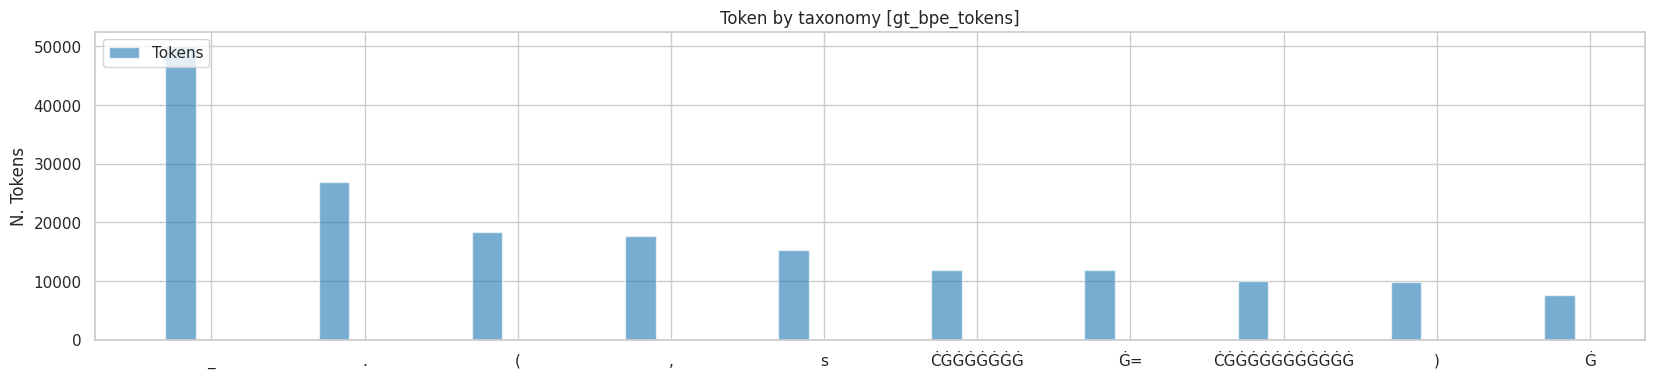

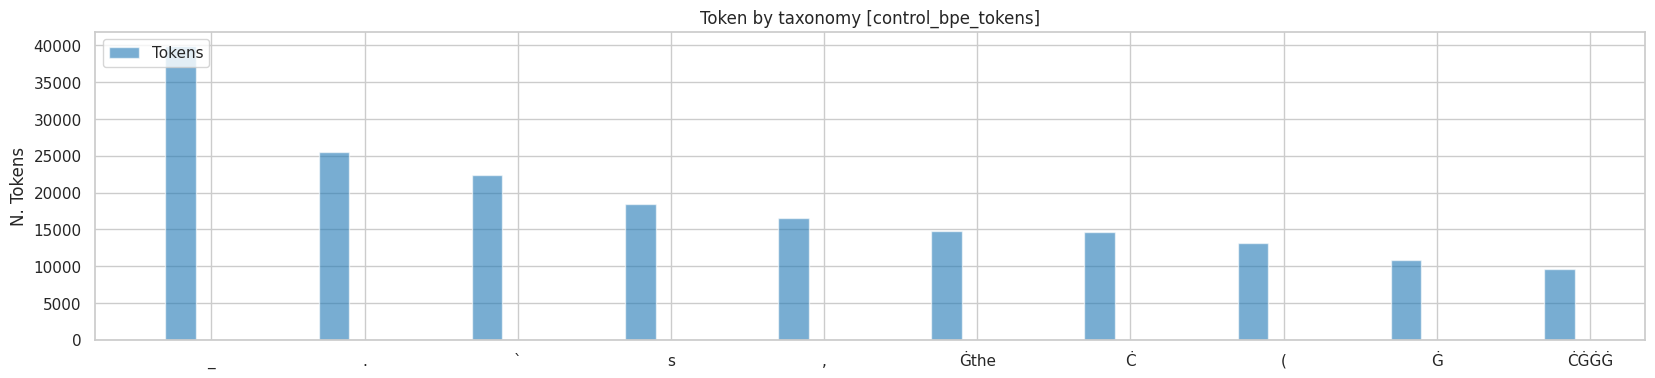

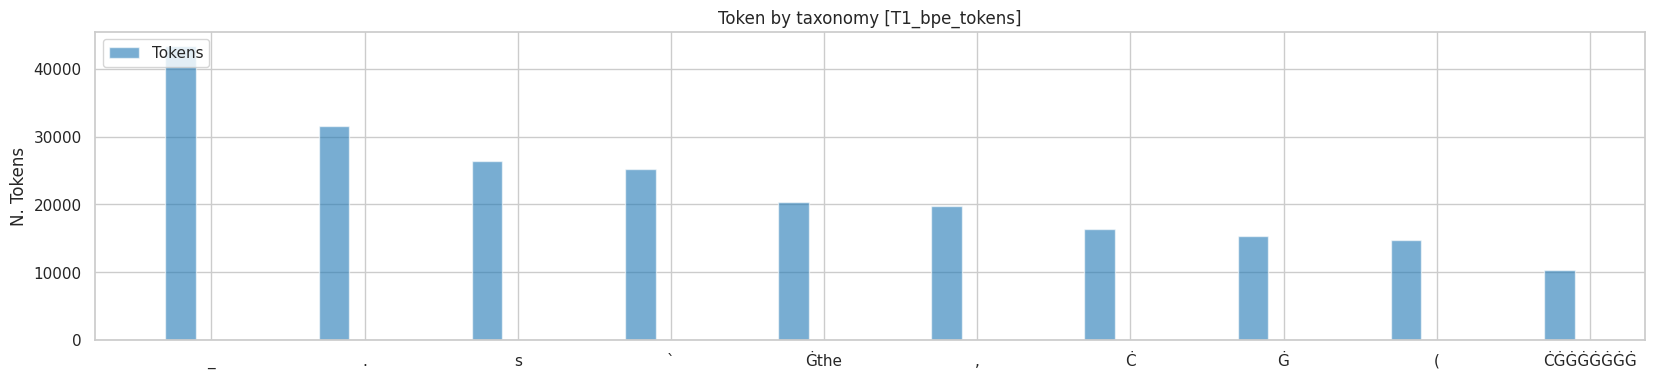

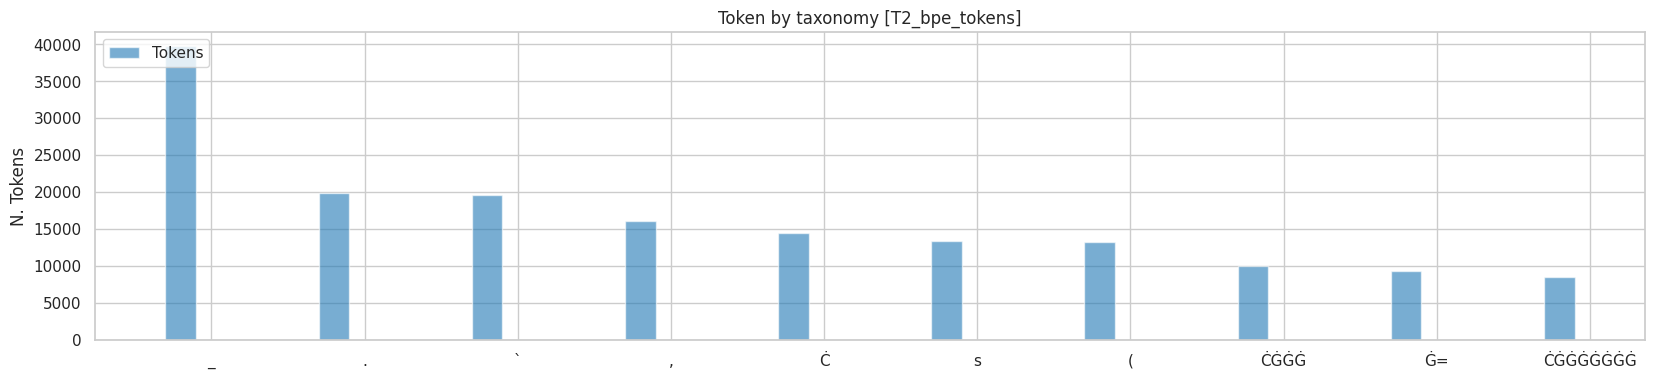

In [101]:
#printing most popular tokens
for key in dict_most:
    fig, axs = plt.subplots( figsize=(20,4), ncols=1 )
    print_token_distribution( [dict_most[key][0]] , ax = axs, label=['Tokens'], log=False, title= '['+key+']')

In [102]:
focused_tokens = { split :  count_by_taxonomy_list( dct_control[split], k_token = proposed_token , stringent=True )  for split in dct_control}

In [103]:
focused_tokens_non['gt_bpe_tokens'][0]

{'assert': 1341,
 'test': 1479,
 'def': 3058,
 'class': 275,
 'lambda': 0,
 'if': 4782,
 'else': 1128,
 'for': 2708}

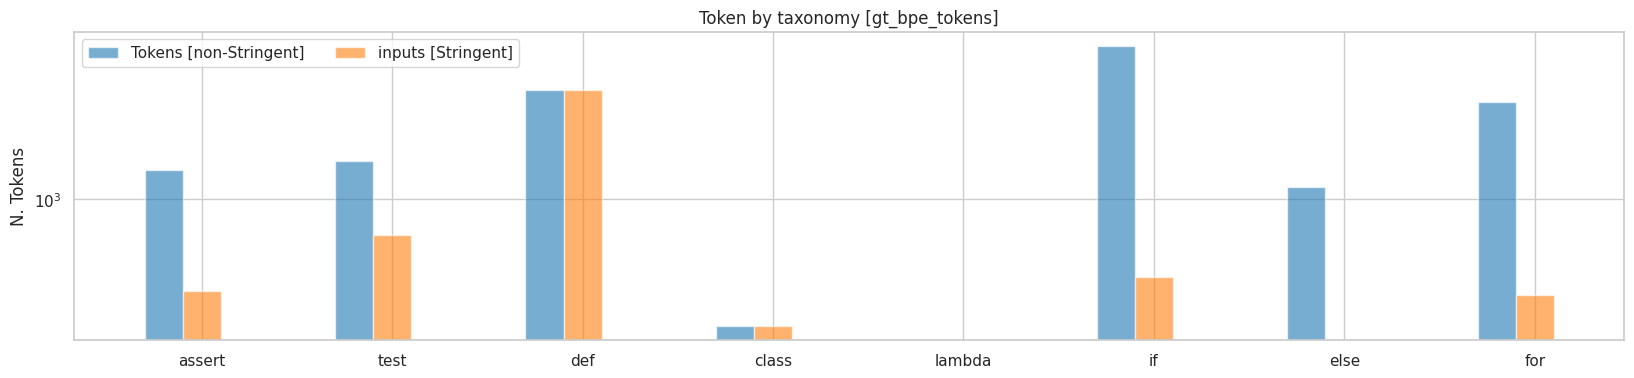

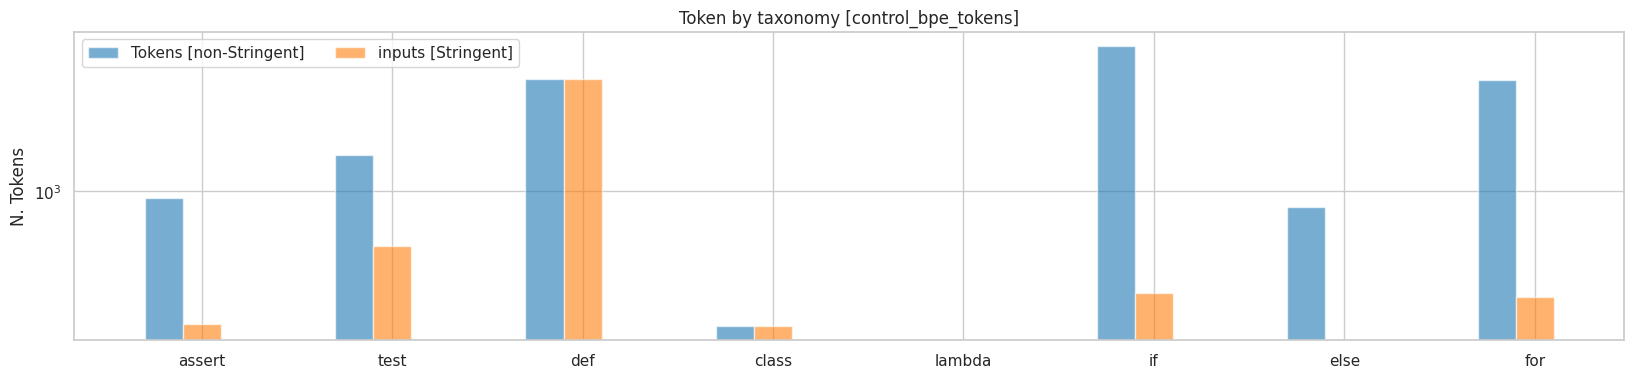

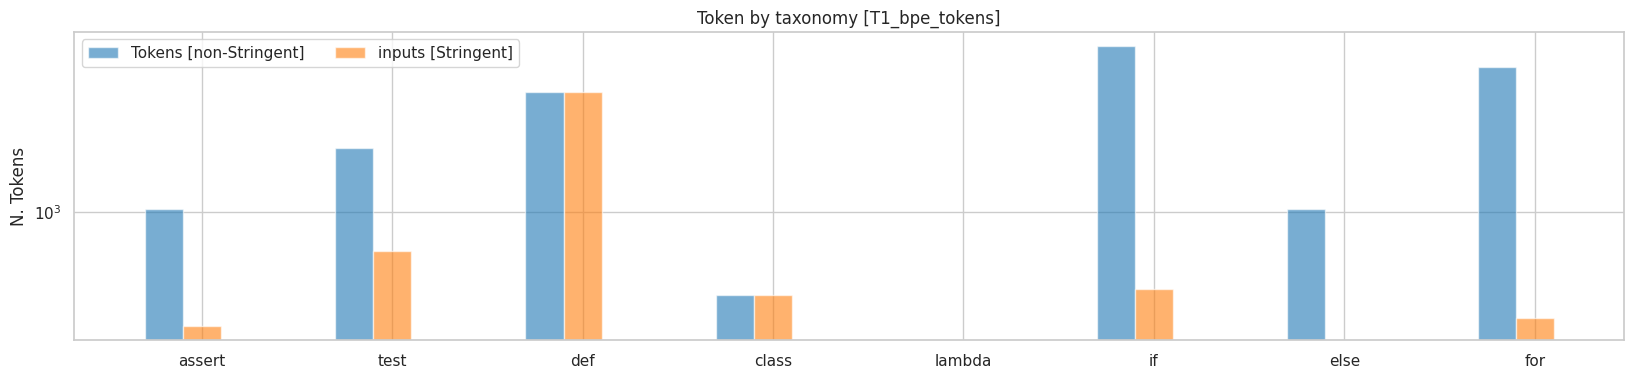

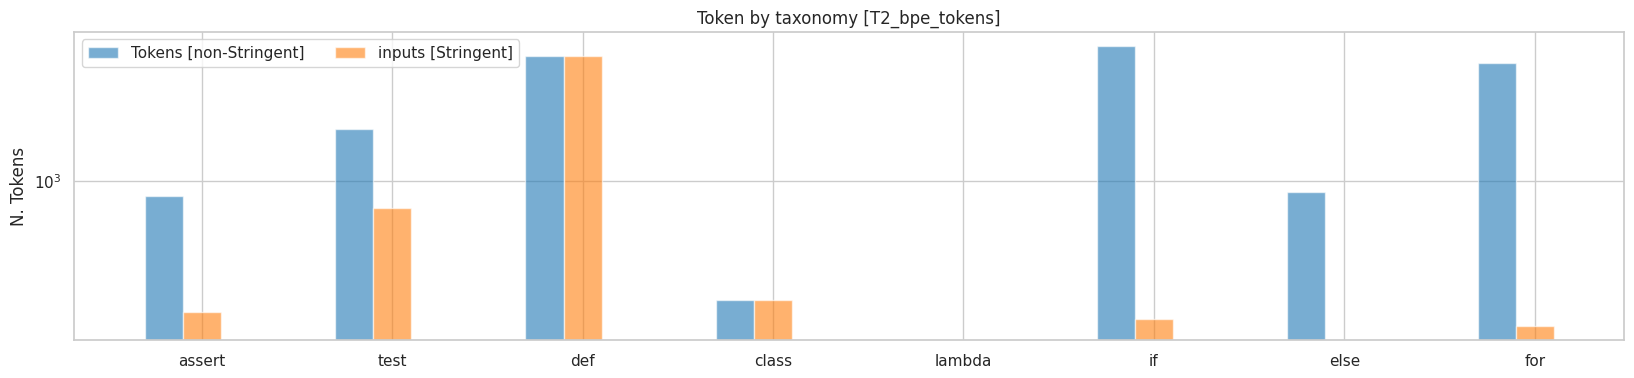

In [104]:
#printing selected (interesting) tokens
#print_token_distribution( [focused_tokens_non,focused_tokens] , label=['non-Stringent','Stringent'], log=True )

#printing most popular tokens
for key in treatments:
    fig, axs = plt.subplots( figsize=(20,4), ncols=1 )
    print_token_distribution( [focused_tokens_non[key][0],focused_tokens[key][0]], ax=axs,  label=['Tokens [non-Stringent]','inputs [Stringent]'], log=True, title='['+key+']' )


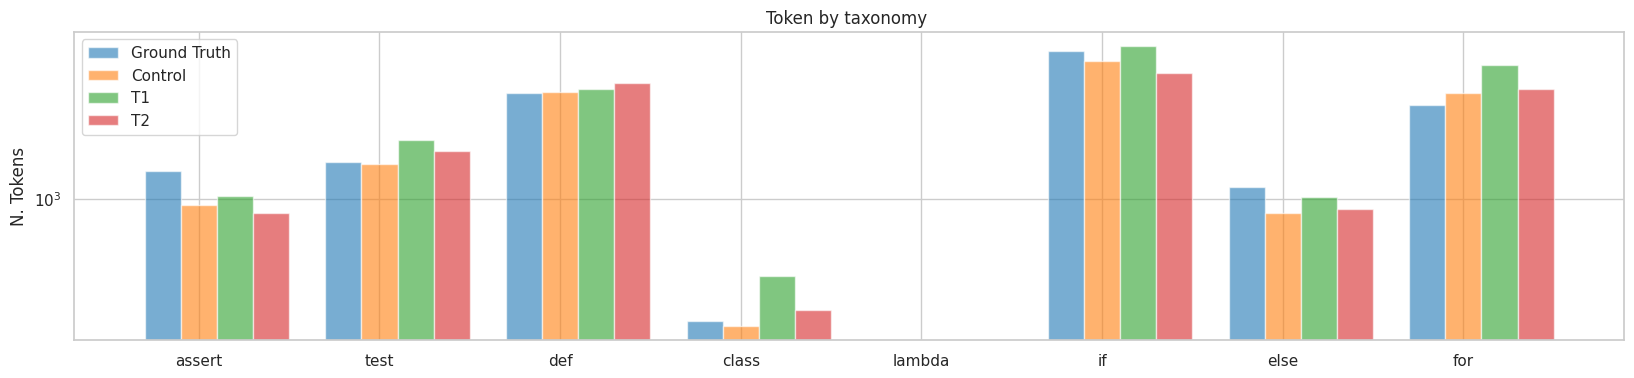

In [105]:
#printing selected (interesting) tokens
#print_token_distribution( [focused_tokens_non,focused_tokens] , label=['non-Stringent','Stringent'], log=True )

#printing most popular tokens
data_to_print = []
for key in treatments:
    data_to_print.append(focused_tokens_non[key][0])
fig, axs = plt.subplots( figsize=(20,4), ncols=1 )
print_token_distribution( data_to_print, ax=axs,  label=treatments, log=True )
axs.legend(series)
plt.show()


In [106]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<:>": ":",
    "<return>": "return",
    "<pass>":"pass"
  },
  "exceptions": {
    "<except>": "except",
    "<try>": "try",
    "<finally>": "finally",
    "<raise>": "raise"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<this>": "this",
    "<from>": "from",
    "<import>": "import",
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<import>": "import",
    "<from>": "from",
    "<synchronized>": "synchronized",
    "<await>": "await",
    "<volatile>": "volatile",
    "<final>": "final",
    "<enum>": "enum",
    "<async>":" async",
    "<break>":"break"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "casting": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<str>": "str",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<none>": "none",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [123]:
#export
def token_taxonomy() -> dict:
    return {
  "exceptions": {
    "<except>": "except",
    "<try>": "try",
    "<finally>": "finally",
    "<raise>": "raise"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<this>": "this",
    "<from>": "from",
    "<import>": "import",
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<import>": "import",
    "<from>": "from",
    "<synchronized>": "synchronized",
    "<await>": "await",
    "<volatile>": "volatile",
    "<final>": "final",
    "<enum>": "enum",
    "<async>":" async",
    "<break>":"break"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  
  "casting": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<str>": "str",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<none>": "none",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [124]:
tkn_taxonomy = token_taxonomy()

In [125]:
tkn_taxonomy['extra_tokens'].values()

dict_values(['@', '...', 'null', 'none', 'true', 'false', '\n'])

In [126]:
dct_control.keys()

dict_keys(['gt_bpe_tokens', 'control_bpe_tokens', 'T1_bpe_tokens', 'T2_bpe_tokens'])

In [127]:
def taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=False ):
    ''''Hardcoded version of taxonomy counting'''
    dict_tokens = {}
    for split in dct_control:
        to_flat_tax_dict = { tax :  count_by_taxonomy_list( dct_control[split], k_token = tkn_taxonomy[tax].values() , stringent=stringent )  for tax in tkn_taxonomy }
        to_flat_tax_dict = { tax : [ functools.reduce(lambda a, b: a+b, list_dict.values() ) for list_dict in to_flat_tax_dict[tax] ] for tax in to_flat_tax_dict }
        dict_tokens[split] = [ 
                { tax: to_flat_tax_dict[tax][0] for tax in to_flat_tax_dict } #Hardcoded Output
            ]
    return dict_tokens

In [128]:
flat_dict_foc_tax_non = taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=False )
flat_dict_foc_tax_str = taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=True )

In [129]:
flat_dict_foc_tax_non['gt_bpe_tokens'][0]

{'exceptions': 1342,
 'oop': 1582,
 'tests': 1341,
 'declarations': 1096,
 'conditionals': 6355,
 'loops': 2907,
 'casting': 1761,
 'extra_tokens': 355}

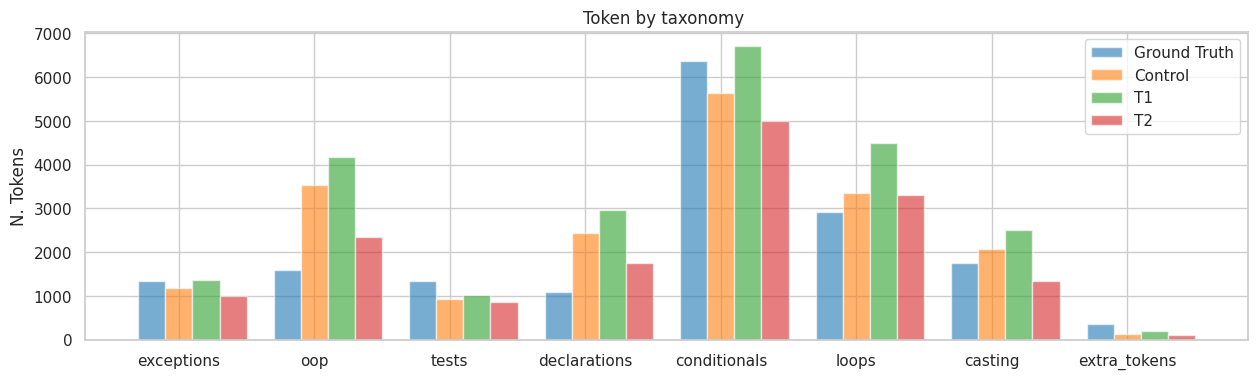

In [130]:
data_to_print = []
for key in treatments:
    data_to_print.append(flat_dict_foc_tax_non[key][0])
fig, axs = plt.subplots( figsize=(15,4), ncols=1 )
print_token_distribution( data_to_print, ax=axs,  label=treatments, log=False, width = 0.2 )
axs.legend(series)
plt.show()

In [51]:
data_to_print = []
for key in treatments:
    data_to_print.append(flat_dict_foc_tax_non[key][0])
fig, axs = plt.subplots( figsize=(15,4), ncols=1 )
print_token_distribution( data_to_print, ax=axs,  label=treatments, log=False, width = 0.2 )
axs.legend(series)
plt.show()

NameError: name 'treatments' is not defined

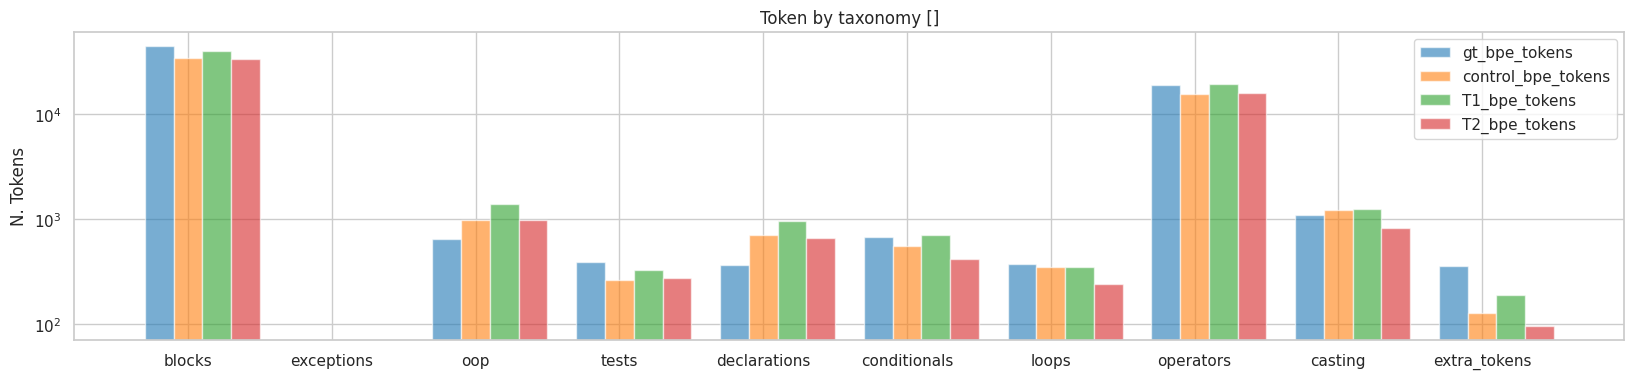

In [170]:
data_to_print = []
for key in treatments:
    data_to_print.append(flat_dict_foc_tax_str[key][0])
fig, axs = plt.subplots( figsize=(20,4), ncols=1 )
plt.legend(series)
print_token_distribution( data_to_print, ax=axs,  label=treatments, log=True, title='[]', width = 0.2 )


In [106]:
treatments

['gt_bpe_tokens', 'control_bpe_tokens', 'T1_bpe_tokens', 'T2_bpe_tokens']

Pending plots for all treatments all in once